In [ ]:
!pip install gymnax

In [5]:
import gymnax
import jax
import jax.numpy as jnp
import random
from tqdm.auto import tqdm

In [50]:
class UCBAgent:
  def __init__(self, n_arms, c_val):
    self.n_arms = n_arms
    self.c_val = c_val
    self.N = jnp.zeros(n_arms)
    self.Q = jnp.zeros(n_arms)
    self.t = 0
    self.untried = jnp.arange(self.n_arms)

  def _select_ucb(self):
    ucb = self.Q + self.c_val * jnp.sqrt(jnp.log(self.t) / (self.N + 1e-10))
    return jnp.argmax(ucb)


  def _get_untried(self):
      return jnp.argmin(self.N)

  def get_arm(self, rng: jax.random.PRNGKey):
    untried_mask = self.N == 0

    select_action = jax.lax.cond(
        jnp.any(self.N == 0),
        self._get_untried,
        self._select_ucb
    )

    return int(select_action)

  def update(self, action, reward):
    self.N = self.N.at[action].add(1)

    self.Q = self.Q.at[action].add((reward - self.Q[action]) / self.N[action])

    self.t += 1

  def reset(self):
    self.N = jnp.zeros(self.n_arms)
    self.Q = jnp.zeros(self.n_arms)
    self.t = 0
    self.untried = jnp.arange(self.n_arms)


In [ ]:
def train(
    env_name: str,
    num_episodes: int = 1000,
    c: float = 2.0,
):


  env, env_params = gymnax.make(env_name)
  agent = UCBAgent(env.num_actions, c)
  randInt = random.randint(0, 1000)
  prngKey = jax.random.PRNGKey(randInt)
  rng, rng_reset = jax.random.split(prngKey)
  obs, env_state = env.reset(rng_reset, env_params)


  if hasattr(env_state, 'reward_probs'):
        true_values = env_state.reward_probs
  elif hasattr(env_state, 'p'):
      true_values = env_state.p
  elif hasattr(env_state, 'probs'):
      true_values = env_state.probs
  elif hasattr(env_state, 'mu'):
      true_values = env_state.mu
  else:
      print(f"Could not find true values. Available: {vars(env_state)}")
      true_values = jnp.zeros(env.num_actions)


  rewards = []
  actions = []
  regret = []


  with tqdm(total=num_episodes) as pbar:
    for episode in range(num_episodes):
      rng, rng_action = jax.random.split(rng)
      action = agent.get_arm(rng_action)
      rng, rng_step = jax.random.split(rng)
      obs, env_state, reward, done, info = env.step(
              rng_step, env_state, action, env_params
          )
      agent.update(action, float(reward))
      actions.append(action)
      rewards.append(reward)
      pbar.desc = f"Episode {episode + 1}/{num_episodes}, reward {reward}"
      pbar.update(1)
  return {
      "actions": actions,
      "rewards": rewards,
      "num_episodes": num_episodes,
      "Q_final": agent.Q,
      "N_final": agent.N,
      "true_values": true_values,
      "c": c,
  }

In [51]:
data = train("BernoulliBandit-misc", 2000, c=2.0)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [52]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

def plot_results(results: dict, window_size: int = 50):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    rewards = jnp.array(results['rewards'])
    cumulative_reward = jnp.cumsum(rewards)
    axes[0, 0].plot(cumulative_reward)
    axes[0, 0].set_xlabel('Steps')
    axes[0, 0].set_ylabel('Cumulative Reward')
    axes[0, 0].set_title('Cumulative Reward')
    axes[0, 0].grid(True, alpha=0.3)


    moving_avg = jnp.convolve(rewards, jnp.ones(window_size)/window_size, mode='valid')
    axes[0, 1].plot(moving_avg)
    axes[0, 1].set_xlabel('Steps')
    axes[0, 1].set_ylabel('Average Reward')
    axes[0, 1].set_title(f'Moving Average Reward (window={window_size})')
    axes[0, 1].grid(True, alpha=0.3)


    n_arms = len(results['Q_final'])
    axes[1, 0].bar(range(n_arms), results['N_final'])
    axes[1, 0].set_xlabel('Arm')
    axes[1, 0].set_ylabel('Times Selected')
    axes[1, 0].set_title('Action Selection Counts')
    axes[1, 0].grid(True, alpha=0.3, axis='y')


    x = jnp.arange(n_arms)
    width = 0.35


    if 'true_values' in results:
        axes[1, 1].bar(x - width/2, results['true_values'], width, label='True Values', alpha=0.7)

    axes[1, 1].bar(x + width/2, results['Q_final'], width, label='Estimated Values', alpha=0.7)
    axes[1, 1].set_xlabel('Arm')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_title('True vs Estimated Action Values')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

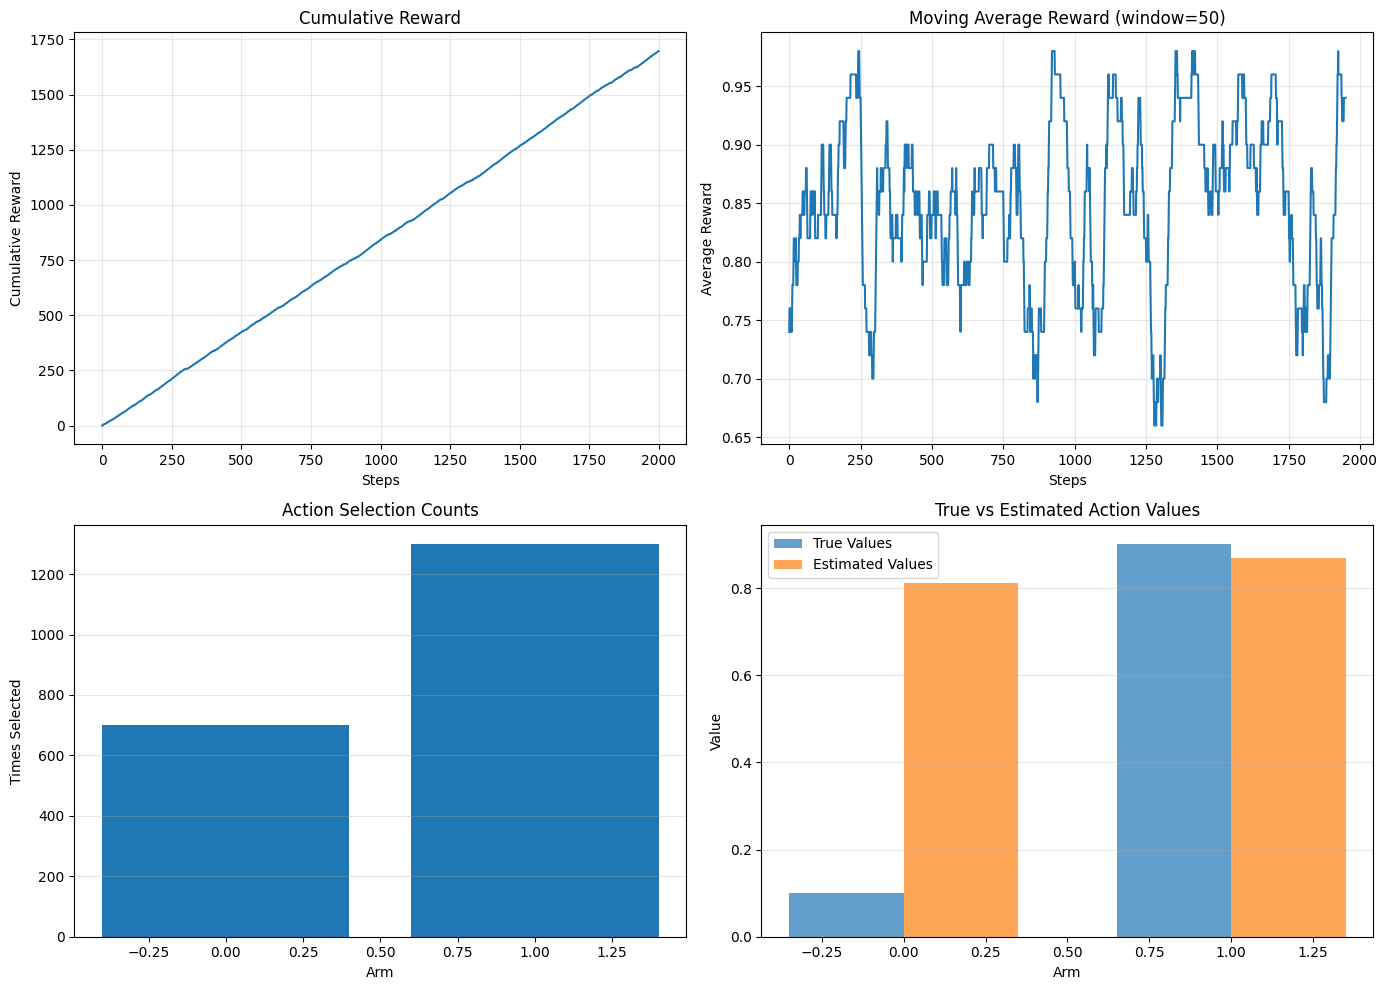

In [53]:
plot_results(data)

In [13]:
all_envs = gymnax.registered_envs
bandit_envs = [env for env in all_envs if 'Bandit' in env]
print("Available bandit environments:", bandit_envs)

Available bandit environments: ['MNISTBandit-bsuite', 'SimpleBandit-bsuite', 'BernoulliBandit-misc', 'GaussianBandit-misc']


In [16]:
env, env_params = gymnax.make("BernoulliBandit-misc")


print("Environment attributes:")
print([attr for attr in dir(env) if not attr.startswith('_')])

print(f"Has 'num_arms'? {hasattr(env, 'num_arms')}")
print(f"Has 'n_arms'? {hasattr(env, 'n_arms')}")
print(f"Has 'action_space'? {hasattr(env, 'action_space')}")

if hasattr(env, 'action_space'):
    print(f"Action space: {env.action_space}")
    print(f"Number of actions: {env.action_space.n}")

Environment attributes:
['action_space', 'default_params', 'discount', 'get_obs', 'is_terminal', 'name', 'num_actions', 'observation_space', 'reset', 'reset_env', 'state_space', 'step', 'step_env']
Has 'num_arms'? False
Has 'n_arms'? False
Has 'action_space'? True
Action space: <bound method BernoulliBandit.action_space of <gymnax.environments.misc.bernoulli_bandit.BernoulliBandit object at 0x7fa37a7ed460>>


AttributeError: 'function' object has no attribute 'n'